In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset
from torchvision.datasets import ImageFolder
#from torchmetrics.functional.classification import multiclass_precision
#from torchmetrics.functional.classification import multiclass_recall
from google.colab import drive
import cv2
import glob
from matplotlib import pyplot as plt

In [ ]:
from torchvision.models import resnet50
from torchvision.models import vgg16
from torchvision.models import alexnet

In [ ]:
torch.manual_seed(1234) 

In [ ]:
resnet50_m = resnet50(weights = 'IMAGENET1K_V1')
vgg16_m = vgg16(weights = 'IMAGENET1K_V1')
alexnet_m = alexnet(weights = 'IMAGENET1K_V1')

In [ ]:
device = torch.device('cuda')
resnet50_m = resnet50_m.to(device)
vgg16_m = vgg16_m.to(device)
alexnet_m = alexnet_m.to(device)


In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))
    ])

In [ ]:
testset = ImageFolder(root="/content/drive/MyDrive/tests",transform=transform)
data_loader = DataLoader(testset, batch_size=1, shuffle=False)

In [ ]:
import csv

with open('/content/drive/MyDrive/imagenet_classes.txt') as f:
  classes = dict(csv.reader(f))

classes

In [ ]:
true_labels = [1,35,88,169,456,463,492,721,859,954]

In [ ]:
def softmax(x):
    x = x.cpu().numpy()
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def predict(model,img):
  img = transform(img)
  img = img.to(device).unsqueeze(0)
  with torch.no_grad():
    logits = model(img)
    
    pre_label = logits.argmax(dim=1)
  top5_labels = torch.topk(logits.flatten(), 5).indices
  top5_prob = torch.topk(logits.flatten(), 5).values
  probs = softmax(top5_prob)
  print("На изображении:", classes.get(str(top5_labels[0].item())),"Номер класса:", top5_labels[0].item())
  print(probs)
  
  print((top5_labels))

На изображении:  bucket Номер класса: 463
[0.8761835  0.07546049 0.02102936 0.01467674 0.01264986]
tensor([463, 412, 469, 544, 876], device='cuda:0')


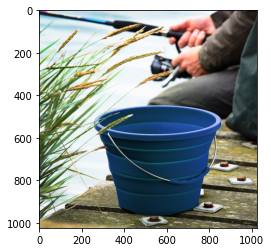

In [ ]:
img = Image.open("/content/drive/MyDrive/bu.jpg")
plt.imshow(img)
predict(alexnet_m, img )

In [ ]:
def accuracy(model,loader):
    correct_num = 0
    correct_num_top5 = 0
    total_num = len(loader.dataset)
    i = 0

    for img,label in loader:

        true_label = torch.tensor(true_labels[label[0]]) 
        #true_label = label 
        img,true_label = img.to(device),true_label.to(device)

        with torch.no_grad():
            logits = model(img)
            pre_label = logits.argmax(dim=1)
        
        top3 = torch.topk(logits.flatten(), 5).indices
        correct_num += torch.eq(pre_label,true_label).sum().float().item()
        
        correct_num_top5 += torch.eq(top3[0],true_label).sum().float().item()
        correct_num_top5 += torch.eq(top3[1],true_label).sum().float().item()
        correct_num_top5 += torch.eq(top3[2],true_label).sum().float().item()
        correct_num_top5 += torch.eq(top3[3],true_label).sum().float().item()
        correct_num_top5 += torch.eq(top3[4],true_label).sum().float().item()


        #print("Предсказанный класс:",classes.get(str(pre_label[0].item())),"номер:",pre_label[0].item()
                #," Реальный класс:",classes.get(str(true_label.item())))
        #print("Предсказанный класс:",pre_label[0].item()," Реальный класс:",true_label.item())
        #print("Топ 5:",top3)

        i += 1

    print("Top 1 Accuracy", correct_num/total_num)
    print("Top 5 Accuracy", correct_num_top5/total_num)
  
    return correct_num/total_num, correct_num_top5/total_num 

In [ ]:
top1, top5 = accuracy(alexnet_m, data_loader)

Top 1 Accuracy 0.2222222222222222
Top 5 Accuracy 0.24444444444444444


In [ ]:
accuracy(vgg16_m, data_loader)

Top 1 Accuracy 0.2222222222222222
Top 5 Accuracy 0.24444444444444444


(0.2222222222222222, 0.24444444444444444)

In [ ]:
accuracy(resnet50_m, data_loader)

Top 1 Accuracy 0.06666666666666667
Top 5 Accuracy 0.1111111111111111


(0.06666666666666667, 0.1111111111111111)